In [2]:
%pip install -r requirements.txt

# Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
from torch.utils.data import TensorDataset, DataLoader
from tsai.all import *
from sklearn.metrics import f1_score
from fastai.metrics import AccumMetric
import optuna
from optuna.integration import FastAIPruningCallback
from datetime import timedelta


In [2]:
my_setup(optuna)

os              : Windows-10-10.0.22631-SP0
python          : 3.11.7
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
optuna          : 3.5.0
torch           : 2.1.2+cu118
device          : 1 gpu (['NVIDIA GeForce RTX 4070'])
cpu cores       : 16
threads per cpu : 1
RAM             : 63.84 GB
GPU memory      : [11.99] GB


In [3]:
set_seed(42)

def set_every_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_every_seed(seed)
tqdm.pandas()

In [4]:
pd.set_option("display.max_columns", 70)
pd.set_option("display.max_rows", 1000)

# Preparation

## Prepare dfs

In [5]:
match_h1 = pd.read_csv(r"handball_sample\MD15_Flensburg_Melsungen\SG_Flensburg-Handewitt_vs._MT__phase_1.HZ_positions.csv", sep=";")
match_h2 = pd.read_csv(r"handball_sample\MD15_Flensburg_Melsungen\SG_Flensburg-Handewitt_vs._MT__phase_2.HZ_positions.csv", sep=";")
tags = pd.read_csv(r"handball_sample\MD15_Flensburg_Melsungen\tags_flensburg_melsungen_md15_s2324.csv", sep=";")

In [6]:
tags

,# time (in ms),tag text,player
0,34483,4_johannes_golla,NaN
1,36553,64_lasse_moller,NaN
2,42181,24_jim_gottfridsson,NaN
3,47370,4_johannes_golla,NaN
4,52051,31_emil_jakobsen,NaN
...,...,...,...
1824,5728269,55_ivan_martinovic,NaN
1825,5730855,43_blaz_blagotinsek,NaN
1826,5731626,20_kevin_moller,NaN
1827,5733816,14_teitur_orn_einarsson,NaN


In [7]:
match_h1.head()

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,heart rate in bpm,core temperature in celsius,metabolic power in W/kg,player orientation in deg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load,Unnamed: 23
0,1701457270300,01.12.2023 20:01:10.300,43678,1471,13,Rogerio Moraes Ferreira,876158,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1701457270300,01.12.2023 20:01:10.300,43591,214,4,Johannes Golla,876390,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1701457270300,01.12.2023 20:01:10.300,43652,1809,33,Kay Smits,1028401,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1701457270300,01.12.2023 20:01:10.300,43603,1104,20,Kevin Møller,592178,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1701457270300,01.12.2023 20:01:10.300,43632,1522,26,Johan Hansen,1340010,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
match_h2.tail()

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,heart rate in bpm,core temperature in celsius,metabolic power in W/kg,player orientation in deg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load,Unnamed: 23
540904,1701462948900,01.12.2023 21:35:48.900,43659,1811,43,Blaz Blagotinsek,797318,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,1143.755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540905,1701462948900,01.12.2023 21:35:48.900,43694,1473,55,Ivan Martinovic,1514831,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,887.336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540906,1701462948900,01.12.2023 21:35:48.900,50455,1106,31,Emil Jakobsen,1637708,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,2055.788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540907,1701462948900,01.12.2023 21:35:48.900,43670,83,5,Julius Kühn,257859,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,869.658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540908,1701462948900,01.12.2023 21:35:48.900,43591,214,4,Johannes Golla,876390,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,2024.557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
match_full = pd.concat([match_h1, match_h2]).reset_index().drop(["index", "heart rate in bpm", "core temperature in celsius", "player orientation in deg",  "Unnamed: 23"], axis=1)
match_full

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,metabolic power in W/kg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load
0,1701457270300,01.12.2023 20:01:10.300,43678,1471,13,Rogerio Moraes Ferreira,876158,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
1,1701457270300,01.12.2023 20:01:10.300,43591,214,4,Johannes Golla,876390,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
2,1701457270300,01.12.2023 20:01:10.300,43652,1809,33,Kay Smits,1028401,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
3,1701457270300,01.12.2023 20:01:10.300,43603,1104,20,Kevin Møller,592178,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
4,1701457270300,01.12.2023 20:01:10.300,43632,1522,26,Johan Hansen,1340010,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077569,1701462948900,01.12.2023 21:35:48.900,43659,1811,43,Blaz Blagotinsek,797318,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,1143.755,NaN,NaN,NaN,NaN
1077570,1701462948900,01.12.2023 21:35:48.900,43694,1473,55,Ivan Martinovic,1514831,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,887.336,NaN,NaN,NaN,NaN
1077571,1701462948900,01.12.2023 21:35:48.900,50455,1106,31,Emil Jakobsen,1637708,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,2055.788,NaN,NaN,NaN,NaN
1077572,1701462948900,01.12.2023 21:35:48.900,43670,83,5,Julius Kühn,257859,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,869.658,NaN,NaN,NaN,NaN


In [10]:
match_full["formatted local time"] = pd.to_datetime(match_full["formatted local time"])

In [11]:
tags.drop(["player"], axis=1, inplace=True)

# Data Understanding

## General

In [13]:
# See where multiple players get possession at same time
match_ball_poss = match_full[~np.isnan(match_full["ball possession (id of possessed ball)"])]
dups = match_ball_poss[match_ball_poss.duplicated(["ts in ms", "ball possession (id of possessed ball)"], keep=False)]
counts = dups.groupby(["ts in ms", "ball possession (id of possessed ball)"]).size()
rows_with_two_or_more = counts[counts >= 2].reset_index()
result = match_ball_poss.merge(rows_with_two_or_more, on=["ts in ms", "ball possession (id of possessed ball)"])
result

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,metabolic power in W/kg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load,0
0,1701457276950,2023-01-12 20:01:16.950,43664,827,64,Lasse Møller,1397085,1,SG Flensburg-Handewitt,4.589,6.437,1.6,1.265,6.992,0.058,6.210,4.658,Forward,1209.0,0.776,2
1,1701457276950,2023-01-12 20:01:16.950,50455,1106,31,Emil Jakobsen,1637708,1,SG Flensburg-Handewitt,6.997,8.784,1.6,1.694,30.682,-0.235,8.464,5.374,Forward,1209.0,0.813,2
2,1701457277000,2023-01-12 20:01:17.000,43664,827,64,Lasse Møller,1397085,1,SG Flensburg-Handewitt,4.651,6.444,1.6,1.275,6.867,0.062,6.210,4.673,Forward,1209.0,0.775,2
3,1701457277000,2023-01-12 20:01:17.000,50455,1106,31,Emil Jakobsen,1637708,1,SG Flensburg-Handewitt,7.085,8.837,1.6,1.694,30.612,-0.340,8.464,5.067,Forward,1209.0,0.802,2
4,1701457277050,2023-01-12 20:01:17.050,43664,827,64,Lasse Møller,1397085,1,SG Flensburg-Handewitt,4.738,6.461,1.6,1.286,6.743,0.060,6.210,4.706,Forward,1209.0,0.775,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33037,1701462879700,2023-01-12 21:34:39.700,43609,212,24,Jim Gottfridsson,345559,1,SG Flensburg-Handewitt,-14.646,5.362,1.6,3.555,167.019,-2.319,1432.623,7.476,Backward,1209.0,5.123,2
33038,1701462879750,2023-01-12 21:34:39.750,43696,1632,18,Florian Drosten,2342241,2,MT Melsungen,-15.851,6.017,1.6,2.718,173.750,NaN,317.077,NaN,Backward,1209.0,5.202,2
33039,1701462879750,2023-01-12 21:34:39.750,43609,212,24,Jim Gottfridsson,345559,1,SG Flensburg-Handewitt,-14.792,5.421,1.6,3.470,166.331,-2.210,1432.623,7.092,Backward,1209.0,4.935,2
33040,1701462879800,2023-01-12 21:34:39.800,43696,1632,18,Florian Drosten,2342241,2,MT Melsungen,-16.006,6.012,1.6,2.631,172.115,NaN,320.571,NaN,Backward,1209.0,5.224,2


In [14]:
grouped = match_full.groupby("formatted local time")["ball possession (id of possessed ball)"].count()
player_count_frequency = grouped.value_counts()
# Sort index for better readability
player_count_frequency = player_count_frequency.sort_index()

player_count_frequency = player_count_frequency.reset_index()
player_count_frequency.columns = ["number_of_players_in_possession", "frequency"]

In [15]:
player_count_frequency

,number_of_players_in_possession,frequency
0,0,15250
1,1,41256
2,2,14883
3,3,1092


In [16]:
print(match_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077574 entries, 0 to 1077573
Data columns (total 20 columns):
 #   Column                                                    Non-Null Count    Dtype         
---  ------                                                    --------------    -----         
 0   ts in ms                                                  1077574 non-null  int64         
 1   formatted local time                                      1077574 non-null  datetime64[ns]
 2   sensor id                                                 1077574 non-null  int64         
 3   mapped id                                                 1077574 non-null  int64         
 4   number                                                    1077574 non-null  int64         
 5   full name                                                 1077574 non-null  object        
 6   league id                                                 1077574 non-null  object        
 7   group id          

In [17]:
match_full.describe()

,ts in ms,formatted local time,sensor id,mapped id,number,group id,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,metabolic power in W/kg,ball possession (id of possessed ball),acceleration load
count,1.077574e+06,1077574,1.077574e+06,1.077574e+06,1.077574e+06,1.077574e+06,1.076793e+06,1.076793e+06,1.076793e+06,1.070160e+06,912606.000000,1.050609e+06,1.077574e+06,978261.000000,74298.000000,1.003692e+06
mean,1.701460e+12,2023-01-12 20:47:37.158630656,6.314546e+04,1.134228e+03,2.778992e+01,1.602391e+00,-4.466552e-01,-3.932669e-01,1.734952e+00,1.552722e+00,-3.443228,-6.846365e-03,9.804397e+02,5.233339,1208.999489,1.562141e+00
min,1.701457e+12,2023-01-12 20:01:10.300000,4.359100e+04,8.300000e+01,4.000000e+00,1.000000e+00,-2.569300e+01,-1.475000e+01,0.000000e+00,0.000000e+00,-180.000000,-1.668910e+02,0.000000e+00,0.000000,1207.000000,1.500000e-02
25%,1.701458e+12,2023-01-12 20:17:27.849999872,4.363200e+04,8.270000e+02,1.000000e+01,1.000000e+00,-1.239100e+01,-5.067000e+00,1.600000e+00,4.470000e-01,-96.269750,-3.170000e-01,3.623540e+02,1.466000,1209.000000,6.340000e-01
50%,1.701461e+12,2023-01-12 20:57:15.150000128,4.367200e+04,1.209000e+03,2.000000e+01,2.000000e+00,-1.878000e+00,-2.460000e-01,1.600000e+00,9.160000e-01,-1.156000,-6.000000e-03,7.514660e+02,2.915000,1209.000000,9.810000e-01
75%,1.701462e+12,2023-01-12 21:16:56.750000128,4.368000e+04,1.522000e+03,3.100000e+01,2.000000e+00,1.203400e+01,4.155000e+00,1.600000e+00,1.770000e+00,82.893750,2.860000e-01,1.271440e+03,5.593000,1209.000000,2.335000e+00
max,1.701463e+12,2023-01-12 21:35:48.900000,3.274450e+05,1.877000e+03,9.900000e+01,3.000000e+00,2.375600e+01,1.246300e+01,2.000000e+01,3.206100e+01,180.000000,1.947520e+02,7.129592e+03,96.099000,1209.000000,3.166200e+01
std,1.850443e+06,NaN,7.092948e+04,5.817673e+02,2.558969e+01,6.114021e-01,1.263475e+01,5.762259e+00,1.730782e+00,1.963758e+00,108.013127,6.378710e+00,1.008500e+03,7.043955,0.031979,1.291567e+00


# Checking if timestamps in video and tabular data are comparable

## Find unique players of both teams in the game to create the keys txt file

In [18]:
keys_dict = {"league_id": [], "team": [], "jersey_number": [], "name": []}
for id in match_full["league id"].unique():
    if "Ball" not in id:
        row = match_full[match_full["league id"] == id].iloc[0]
        keys_dict["league_id"].append(row["league id"])
        keys_dict["team"].append(row["group name"])
        keys_dict["jersey_number"].append(row["number"])
        keys_dict["name"].append(row["full name"])

keys_df = pd.DataFrame(keys_dict)

In [24]:
tags["tag text"].replace("20_kevin_moller", "20_kevin_møller", inplace=True)
tags["tag text"].replace("63_lasse_moller", "63_lasse_møller", inplace=True)
tags["tag text"].replace("11_petter_overby", "11_petter_øverby", inplace=True)
tags["tag text"].replace("71_elias_eliefsen_á_skipagotu", "71_elias_eliefsen_á_skipagøtu", inplace=True)

In [25]:
tags["tag text"].unique()

array(['4_johannes_golla', '64_lasse_moller', '24_jim_gottfridsson',
       '31_emil_jakobsen', 'ball_not_visible', 'game_start',
       'time_check_position', '13_rogerio_moraes_ferreira',
       '33_kay_smits', '26_johan_hansen', '16_nebojsa_simic',
       '6_erik_balenciaga_azcue', '10_dainis_kristopans',
       '20_kevin_møller', '11_dimitri_ignatow', '5_julius_kühn',
       '18_florian_drosten', '8_adrian_sipos', '43_blaz_blagotinsek',
       '22_mads_mensah_larsen', 'no_possession', '73_timo_kastening',
       '14_teitur_orn_einarsson', '55_ivan_martinovic', '7_david_mandic',
       '21_arnar_freyr_arnarsson', '25_lukas_joergensen',
       '27_sindre_andre_aho'], dtype=object)

In [26]:
def change_tag_name(tag):
    if tag != "no_possession" and tag != "time_check_position" and tag != "game_start" and tag != "ball_not_visible":
        first_underscore_pos = tag.find("_")
        name = tag[first_underscore_pos + 1:]
        print(name)

for tag in tags["tag text"].unique():
    change_tag_name(tag)

johannes_golla
lasse_moller
jim_gottfridsson
emil_jakobsen
rogerio_moraes_ferreira
kay_smits
johan_hansen
nebojsa_simic
erik_balenciaga_azcue
dainis_kristopans
kevin_møller
dimitri_ignatow
julius_kühn
florian_drosten
adrian_sipos
blaz_blagotinsek
mads_mensah_larsen
timo_kastening
teitur_orn_einarsson
ivan_martinovic
david_mandic
arnar_freyr_arnarsson
lukas_joergensen
sindre_andre_aho


In [27]:
keys_df.sort_values(["team", "jersey_number"], ascending=[True, True])

,league_id,team,jersey_number,name
12,257859,MT Melsungen,5,Julius Kühn
6,903148,MT Melsungen,6,Erik Balenciaga
21,1386361,MT Melsungen,7,David Mandic
7,1340188,MT Melsungen,8,Adrian Sipos
13,1290098,MT Melsungen,10,Dainis Kristopans
9,1117095,MT Melsungen,11,Dimitri Ignatow
0,876158,MT Melsungen,13,Rogerio Moraes Ferreira
10,905094,MT Melsungen,16,Nebojsa Simic
15,2342241,MT Melsungen,18,Florian Drosten
19,1290560,MT Melsungen,21,Arnar Freyr Arnarsson


## Check time

In [28]:
match_full[~pd.isnull(match_full["player orientation category (forward, back, left, right)"])]

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,metabolic power in W/kg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load
151,1701457270800,2023-01-12 20:01:10.800,43591,214,4,Johannes Golla,876390,1,SG Flensburg-Handewitt,0.603,0.180,1.6,0.480,-37.341,NaN,0.000,NaN,Forward,NaN,1.116
153,1701457270800,2023-01-12 20:01:10.800,43603,1104,20,Kevin Møller,592178,1,SG Flensburg-Handewitt,-5.450,-1.958,1.6,0.516,100.416,NaN,0.000,NaN,Left,NaN,0.495
154,1701457270800,2023-01-12 20:01:10.800,43632,1522,26,Johan Hansen,1340010,1,SG Flensburg-Handewitt,-0.842,-7.487,1.6,1.619,-73.258,NaN,0.000,NaN,Right,NaN,3.053
158,1701457270800,2023-01-12 20:01:10.800,43609,212,24,Jim Gottfridsson,345559,1,SG Flensburg-Handewitt,-0.662,-2.656,1.6,1.162,79.052,NaN,0.000,NaN,Left,1209.0,0.987
162,1701457270800,2023-01-12 20:01:10.800,50455,1106,31,Emil Jakobsen,1637708,1,SG Flensburg-Handewitt,-0.112,3.852,1.6,1.410,99.805,NaN,0.000,NaN,Left,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077134,1701462947450,2023-01-12 21:35:47.450,43659,1811,43,Blaz Blagotinsek,797318,1,SG Flensburg-Handewitt,6.315,-5.848,1.6,1.320,158.767,NaN,1142.055,NaN,Backward,NaN,0.832
1077137,1701462947450,2023-01-12 21:35:47.450,43670,83,5,Julius Kühn,257859,2,MT Melsungen,-5.576,2.825,1.6,1.085,-177.645,NaN,868.392,NaN,Backward,NaN,0.971
1077138,1701462947450,2023-01-12 21:35:47.450,43591,214,4,Johannes Golla,876390,1,SG Flensburg-Handewitt,-3.893,-0.839,1.6,2.461,-169.755,NaN,2024.557,NaN,Backward,NaN,3.052
1077143,1701462947500,2023-01-12 21:35:47.500,43677,95,16,Nebojsa Simic,905094,2,MT Melsungen,-16.328,-0.595,1.6,0.984,175.461,NaN,1079.012,NaN,Backward,NaN,0.612


In [30]:
match_start = match_full[match_full[~np.isnan(match_full["ball possession (id of possessed ball)"])].index[0]:]

In [31]:
match_start_poss = match_start.dropna(subset=["ball possession (id of possessed ball)"])

# Drop consecutive rows where same player is still in possession
match_start_poss = match_start_poss[match_start_poss["sensor id"] != match_start_poss["sensor id"].shift(1)]

In [36]:
match_start.loc[:, "time diff from start"] = match_start.loc[:, "formatted local time"] - match_start["formatted local time"].iloc[0]

### Convert tags timestamp to actual time

In [38]:
tags[tags["tag text"].isin(["time_check_position"])]

,# time (in ms),tag text
9,59290,time_check_position
164,398088,time_check_position
292,682466,time_check_position
448,1047490,time_check_position
622,1585701,time_check_position
746,1887826,time_check_position
899,2427605,time_check_position
923,3431463,time_check_position
1082,3789661,time_check_position
1243,4120249,time_check_position


In [39]:
def round_to_nearest_50ms(dt):
    """ Round the timestamps to nearest 50ms.
    
    Parameters:
    dt -- the datetime timestamps

    Returns:
    rounded_dt -- the timestamps rounded to nearest 50ms
    """
    # Convert microseconds to milliseconds and round to nearest 50 milliseconds
    milliseconds = round(dt.microsecond / 1000.0 / 50.0) * 50
    # Rebuild datetime with new milliseconds, adjusting for overflow
    new_second = dt.second
    if milliseconds >= 1000:
        milliseconds -= 1000
        new_second += 1
    # Ensure seconds don't overflow
    if new_second >= 60:
        new_second -= 60
        dt += timedelta(minutes=1)
    rounded_dt = dt.replace(second=new_second, microsecond=int(milliseconds * 1000))
    return rounded_dt

In [41]:
offset = 350
game = ""
tags["# time (in ms) vid"] = tags["# time (in ms)"]
tags["# time (in ms)"] = tags["# time (in ms)"] - tags["# time (in ms)"][tags["tag text"] == "game_start"].iloc[0]

# Get game start time
if game == "FLEvsEIS":
    table_start_time = pd.to_datetime("2023-10-28 19:02:14.000") # No player has possession in first half of that game according to Kinexon
# elif game == "FLEvsRNL":
#     table_start_time = pd.to_datetime("2023-11-18 18:02:10.650") # Possession starts to late
else:
    table_start_time = match_start_poss["formatted local time"].iloc[0]

 # Create adjusted timestamp column where video time of tags is converted to actual timestamp 
    tags["adjusted_timestamp"] = tags["# time (in ms)"].apply(lambda x: table_start_time + timedelta(milliseconds=x + offset))
    tags["rounded_timestamp"] = tags["adjusted_timestamp"].apply(round_to_nearest_50ms) # Round adjusted timestamps

In [42]:
table_start_time

Timestamp('2023-01-12 20:01:10.800000')

In [43]:
# Forward fill tags df to have correct merging of match and tags df 
video_start_time = tags["rounded_timestamp"].iloc[0]
table_end_time = match_full["formatted local time"].iloc[-1]

all_timestamps = pd.date_range(start=video_start_time, end=table_end_time, freq="50L")
all_timestamps_df = pd.DataFrame(all_timestamps, columns=["timestamp"])

# Merge tags with all timestamps and forward fill
tags_full = pd.merge(all_timestamps_df, tags, left_on="timestamp", right_on="rounded_timestamp", how="left")
tags_full["tag text"].replace(["game_start", "no_possession", "time_check_position"], np.nan, inplace=True)
cols_from_tags = tags.columns.difference(["# time (in ms)", "adjusted_timestamp"])
for col in cols_from_tags:
    tags_full[col] = tags_full[col].ffill()

In [45]:
merged_df = pd.merge(match_full, tags_full, left_on="formatted local time", right_on="timestamp", how="left")
merged_df

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,metabolic power in W/kg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load,timestamp,# time (in ms),tag text,# time (in ms) vid,adjusted_timestamp,rounded_timestamp
0,1701457270300,2023-01-12 20:01:10.300,43678,1471,13,Rogerio Moraes Ferreira,876158,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,4_johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
1,1701457270300,2023-01-12 20:01:10.300,43591,214,4,Johannes Golla,876390,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,4_johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
2,1701457270300,2023-01-12 20:01:10.300,43652,1809,33,Kay Smits,1028401,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,4_johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
3,1701457270300,2023-01-12 20:01:10.300,43603,1104,20,Kevin Møller,592178,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,4_johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
4,1701457270300,2023-01-12 20:01:10.300,43632,1522,26,Johan Hansen,1340010,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,4_johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077629,1701462948900,2023-01-12 21:35:48.900,43659,1811,43,Blaz Blagotinsek,797318,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,1143.755,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,14_teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900
1077630,1701462948900,2023-01-12 21:35:48.900,43694,1473,55,Ivan Martinovic,1514831,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,887.336,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,14_teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900
1077631,1701462948900,2023-01-12 21:35:48.900,50455,1106,31,Emil Jakobsen,1637708,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,2055.788,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,14_teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900
1077632,1701462948900,2023-01-12 21:35:48.900,43670,83,5,Julius Kühn,257859,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,869.658,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,14_teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900


In [49]:
tags[tags["tag text"].isin(["time_check_position"])]

,# time (in ms),tag text,# time (in ms) vid,adjusted_timestamp,rounded_timestamp
9,1211,time_check_position,1211,2023-01-12 20:01:12.361,2023-01-12 20:01:12.350
164,340009,time_check_position,340009,2023-01-12 20:06:51.159,2023-01-12 20:06:51.150
292,624387,time_check_position,624387,2023-01-12 20:11:35.537,2023-01-12 20:11:35.550
448,989411,time_check_position,989411,2023-01-12 20:17:40.561,2023-01-12 20:17:40.550
622,1527622,time_check_position,1527622,2023-01-12 20:26:38.772,2023-01-12 20:26:38.750
746,1829747,time_check_position,1829747,2023-01-12 20:31:40.897,2023-01-12 20:31:40.900
899,2369526,time_check_position,2369526,2023-01-12 20:40:40.676,2023-01-12 20:40:40.700
923,3373384,time_check_position,3373384,2023-01-12 20:57:24.534,2023-01-12 20:57:24.550
1082,3731582,time_check_position,3731582,2023-01-12 21:03:22.732,2023-01-12 21:03:22.750
1243,4062170,time_check_position,4062170,2023-01-12 21:08:53.320,2023-01-12 21:08:53.300


In [56]:
tag_to_check = 0
ts_to_check = tags[tags["tag text"].isin(["time_check_position"])]["rounded_timestamp"].iloc[tag_to_check]
# Find index where first of i-th check-tag is used
try:
    # Get previous and next timestamps based on timestamp to check for consideration
    check_min, check_max = match_full[match_full["formatted local time"] == ts_to_check].index[0] - 150, match_full[match_full["formatted local time"] == ts_to_check].index[0] + 165
except IndexError:
    # If timestamp to check is not available in the data, proceed to next timestamp
    print(ts_to_check, "Data not available")

df_to_check = match_full[match_full["group name"] == "Ball"].loc[check_min:check_max]
if df_to_check.size == 0:
    print("Ball is not found in area to check")

if df_to_check["z in m"].min() > 5:
    # If z value is over 5m in every considered timestamp, proceed to next timestamp
    print(ts_to_check, "Z sensor in ball wrong, this position can't be reliably checked")

time_in_df = df_to_check["formatted local time"][df_to_check["z in m"] == df_to_check["z in m"].min()]

# Print difference between tabular and video times
difference = abs(time_in_df - ts_to_check)
print("Checkpoint", tag_to_check, ", Video", ts_to_check, ", Difference in ms is:", difference.iloc[0].microseconds/1000, ", Tabular", time_in_df.iloc[0])

Checkpoint 0 , Video 2023-01-12 20:01:12.350000 , Difference in ms is: 100.0 , Tabular 2023-01-12 20:01:12.450000


In [58]:
# Player positions in timestamp to check
# merged_df[(merged_df["formatted local time"] >= ts_to_check)].head(15)

In [59]:
df_to_check

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,metabolic power in W/kg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load
475,1701457271850,2023-01-12 20:01:11.850,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.127,-0.781,1.156,2.258,19.784,6.575,1.477,NaN,NaN,NaN,NaN
490,1701457271900,2023-01-12 20:01:11.900,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.180,-0.669,1.168,2.435,21.125,1.909,1.477,NaN,NaN,NaN,NaN
505,1701457271950,2023-01-12 20:01:11.950,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.247,-0.575,1.094,2.423,22.493,-0.827,1.477,NaN,NaN,NaN,NaN
520,1701457272000,2023-01-12 20:01:12.000,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.350,-0.507,0.946,2.311,23.885,0.907,1.477,NaN,NaN,NaN,NaN
535,1701457272050,2023-01-12 20:01:12.050,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.439,-0.447,0.857,2.412,25.302,9.673,1.477,NaN,NaN,NaN,NaN
550,1701457272100,2023-01-12 20:01:12.100,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.485,-0.327,0.839,3.282,26.743,15.842,2.863,NaN,NaN,NaN,NaN
565,1701457272150,2023-01-12 20:01:12.150,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.475,-0.131,0.713,4.168,28.205,7.278,2.863,NaN,NaN,NaN,NaN
580,1701457272200,2023-01-12 20:01:12.200,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.452,0.090,0.393,4.095,29.688,-10.636,2.863,NaN,NaN,NaN,NaN
595,1701457272250,2023-01-12 20:01:12.250,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.485,0.281,0.081,3.054,31.190,-23.772,2.863,NaN,NaN,NaN,NaN
610,1701457272300,2023-01-12 20:01:12.300,327445,1209,99,Ball3 Ball,FlensBall3,3,Ball,0.545,0.376,0.006,1.577,32.710,-22.681,2.863,NaN,NaN,NaN,NaN


# Wrong data

In [63]:
# Group by timestamp and count occurrences
group_counts = match_full.groupby("formatted local time")["group name"].agg(ball_count=lambda x: (x == "Ball").sum(), player_count=lambda x: (x != "Ball").sum()).reset_index()
filtered_timestamps = group_counts[(group_counts["ball_count"] == 1) & (group_counts["player_count"] == 14)]["formatted local time"]

# Filter original DataFrame using these timestamps
filtered_match = match_full[match_full["formatted local time"].isin(filtered_timestamps)]

print(match_full["formatted local time"].nunique())
print(filtered_match["formatted local time"].nunique())

72481
55556


In [64]:
# Usable timestamps 
ts_counts = match_full["formatted local time"].value_counts()
usable_ts = ts_counts[ts_counts >= 15].index
match_full = match_full[match_full["formatted local time"].isin(usable_ts)]
ts_counts_over_15 = match_full["formatted local time"].value_counts()
usable_ts_over_15 = ts_counts[ts_counts > 15].index
match_over_15 = match_full[match_full["formatted local time"].isin(usable_ts_over_15)]
match_over_15["formatted local time"].value_counts()

formatted local time
2023-01-12 20:31:41.750    18
2023-01-12 20:31:41.650    18
2023-01-12 20:31:41.600    18
2023-01-12 20:31:41.800    18
2023-01-12 20:31:41.850    18
                           ..
2023-01-12 20:30:01.650    16
2023-01-12 20:30:01.700    16
2023-01-12 20:30:01.750    16
2023-01-12 20:30:01.800    16
2023-01-12 21:34:51.950    16
Name: count, Length: 4492, dtype: int64

In [65]:
timestamps_with_no_possession = match_full.groupby("formatted local time").filter(lambda x: x["ball possession (id of possessed ball)"].isna().all())

# Unique timestamps where no player has possession of ball
unique_timestamps = timestamps_with_no_possession["formatted local time"].nunique()
unique_timestamps_total = match_full["formatted local time"].nunique()
unique_timestamps_without_inv = merged_df[merged_df["tag text"] != "ball_not_visible"]["formatted local time"].nunique()

print(unique_timestamps) 
print(unique_timestamps_total)
print(unique_timestamps_without_inv)

11784
60048
71877


In [66]:
# Timestamps with wrong z-column sensor data
match_full[match_full["z in m"] > 10]["formatted local time"].unique()

<DatetimeArray>
['2023-01-12 20:20:40.200000', '2023-01-12 20:20:40.250000',
 '2023-01-12 20:20:40.300000', '2023-01-12 20:20:40.350000',
 '2023-01-12 20:20:40.400000', '2023-01-12 20:20:40.450000',
 '2023-01-12 20:20:40.500000', '2023-01-12 20:20:40.550000',
 '2023-01-12 20:20:40.600000', '2023-01-12 20:20:40.650000',
 ...
 '2023-01-12 21:35:48.400000', '2023-01-12 21:35:48.450000',
 '2023-01-12 21:35:48.500000', '2023-01-12 21:35:48.550000',
 '2023-01-12 21:35:48.600000', '2023-01-12 21:35:48.650000',
 '2023-01-12 21:35:48.700000', '2023-01-12 21:35:48.750000',
 '2023-01-12 21:35:48.800000', '2023-01-12 21:35:48.850000']
Length: 6994, dtype: datetime64[ns]

# Statistics

In [69]:
ball_game_counts = group_counts["ball_count"].value_counts()
player_game_counts = group_counts["player_count"].value_counts()

# Sort index for better readability
ball_count_game_frequency = ball_game_counts.sort_index()
player_count_game_frequency = player_game_counts.sort_index()

# Reset index for more informative DataFrame
ball_game_counts = ball_game_counts.reset_index()
ball_game_counts.columns = ["number_of_balls_in_game", "frequency"]
player_game_counts = player_game_counts.reset_index()
player_game_counts.columns = ["number_of_players_in_game", "frequency"]

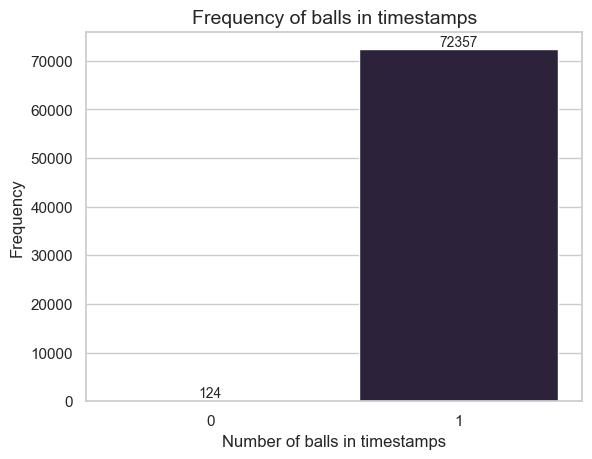

In [71]:
ax = sns.barplot(x="number_of_balls_in_game", y="frequency", data=ball_game_counts, palette="ch:s=.25,rot=-.25")

plt.title("Frequency of balls in timestamps", fontsize=14)
plt.xlabel("Number of balls in timestamps", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Annotate bars with exact frequency
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f"{int(p.get_height())}", 
            fontsize=10, ha="center", va="bottom")

plt.show()

sns.set_theme(style="whitegrid")

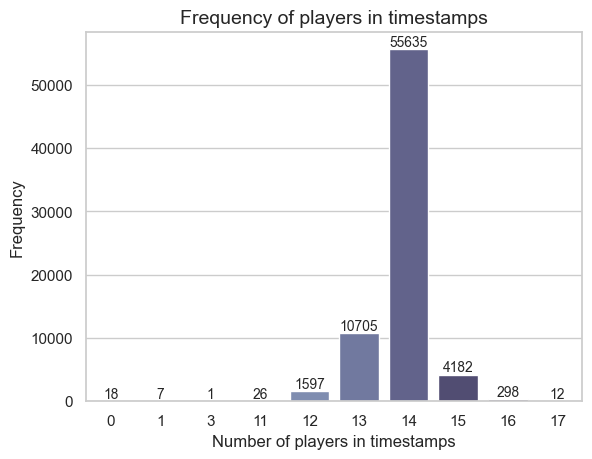

In [72]:
ax = sns.barplot(x="number_of_players_in_game", y="frequency", data=player_game_counts, palette="ch:s=.25,rot=-.25")

plt.title("Frequency of players in timestamps", fontsize=14)
plt.xlabel("Number of players in timestamps", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f"{int(p.get_height())}", 
            fontsize=10, ha="center", va="bottom")

plt.show()

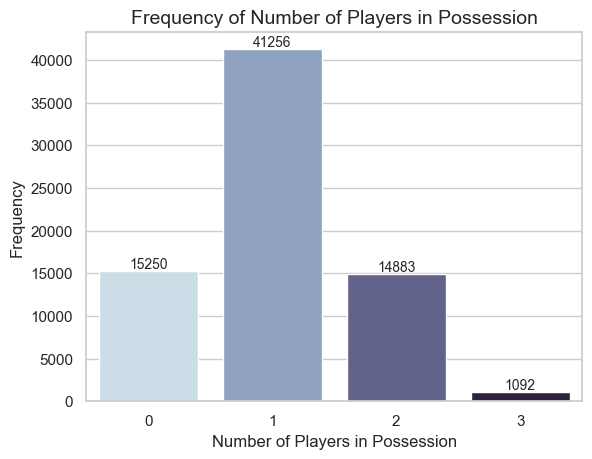

In [73]:
ax = sns.barplot(x="number_of_players_in_possession", y="frequency", data=player_count_frequency, palette="ch:s=.25,rot=-.25")

plt.title("Frequency of Number of Players in Possession", fontsize=14)
plt.xlabel("Number of Players in Possession", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f"{int(p.get_height())}", 
            fontsize=10, ha="center", va="bottom")

plt.show()

In [74]:
merged_df = pd.merge(match_full, tags_full, left_on="formatted local time", right_on="timestamp", how="left")

In [75]:
filtered_merged_df = pd.merge(filtered_match, tags_full, left_on="formatted local time", right_on="timestamp", how="left")

In [76]:
filtered_merged_df["tag text"].unique()

array(['4_johannes_golla', 'ball_not_visible', '24_jim_gottfridsson',
       'game_start', 'time_check_position', '64_lasse_moller',
       '31_emil_jakobsen', '13_rogerio_moraes_ferreira', '33_kay_smits',
       '26_johan_hansen', '16_nebojsa_simic', '6_erik_balenciaga_azcue',
       '10_dainis_kristopans', '20_kevin_møller', '11_dimitri_ignatow',
       '5_julius_kühn', '18_florian_drosten', '8_adrian_sipos',
       '43_blaz_blagotinsek', '22_mads_mensah_larsen', 'no_possession',
       '73_timo_kastening', '14_teitur_orn_einarsson',
       '55_ivan_martinovic', '7_david_mandic', '21_arnar_freyr_arnarsson',
       '25_lukas_joergensen', '27_sindre_andre_aho'], dtype=object)

In [327]:
# filtered_merged_df = pd.read_csv(r"handball_sample\MD05_Flensburg_Kiel\flensburg_kiel_md5_2.csv", sep=";", index_col=0)

In [77]:
filtered_merged_df["full name"] = filtered_merged_df["full name"].str.lower().str.replace(" ", "_")
filtered_merged_df["tag text"] = filtered_merged_df["tag text"].apply(lambda x: x[x.find("_") + 1:])

In [78]:
filtered_merged_df["tag text"].replace("elias_eliefsen_á_skipagotu", "elias_ellefsen_á_skipagøtu", inplace=True)
filtered_merged_df["tag text"].replace("kevin_moller", "kevin_møller", inplace=True)
filtered_merged_df["tag text"].replace("petter_overby", "petter_øverby", inplace=True)
filtered_merged_df["tag text"].replace("mads_mensah_larsen", "mads__mensah_larsen", inplace=True)
filtered_merged_df["tag text"].replace("simon_pytlick", "simon__pytlick", inplace=True)

In [79]:
filtered_merged_df.drop(filtered_merged_df[filtered_merged_df["tag text"] == "not_visible"].index, inplace=True)

In [80]:
filtered_merged_df

,ts in ms,formatted local time,sensor id,mapped id,number,full name,league id,group id,group name,x in m,y in m,z in m,speed in m/s,direction of movement in deg,acceleration in m/s2,total distance in m,metabolic power in W/kg,"player orientation category (forward, back, left, right)",ball possession (id of possessed ball),acceleration load,timestamp,# time (in ms),tag text,# time (in ms) vid,adjusted_timestamp,rounded_timestamp
0,1701457270300,2023-01-12 20:01:10.300,43678,1471,13,rogerio__moraes_ferreira,876158,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
1,1701457270300,2023-01-12 20:01:10.300,43591,214,4,johannes_golla,876390,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
2,1701457270300,2023-01-12 20:01:10.300,43652,1809,33,kay_smits,1028401,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
3,1701457270300,2023-01-12 20:01:10.300,43603,1104,20,kevin_møller,592178,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
4,1701457270300,2023-01-12 20:01:10.300,43632,1522,26,johan_hansen,1340010,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,2023-01-12 20:01:10.300,NaN,johannes_golla,-2683.0,NaT,2023-01-12 20:01:08.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833395,1701462948900,2023-01-12 21:35:48.900,43659,1811,43,blaz_blagotinsek,797318,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,1143.755,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900
833396,1701462948900,2023-01-12 21:35:48.900,43694,1473,55,ivan_martinovic,1514831,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,887.336,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900
833397,1701462948900,2023-01-12 21:35:48.900,50455,1106,31,emil_jakobsen,1637708,1,SG Flensburg-Handewitt,NaN,NaN,NaN,NaN,NaN,NaN,2055.788,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900
833398,1701462948900,2023-01-12 21:35:48.900,43670,83,5,julius_kühn,257859,2,MT Melsungen,NaN,NaN,NaN,NaN,NaN,NaN,869.658,NaN,NaN,NaN,NaN,2023-01-12 21:35:48.900,NaN,teitur_orn_einarsson,5675737.0,NaT,2023-01-12 21:35:46.900


In [81]:
# Show wrong data for all timestamps, including ones where no one in that timestamp has possession
def select_row(group):
    # Check if any row has a non-NaN "ball possession" value
    possession_rows = group.dropna(subset=["ball possession (id of possessed ball)"])
    
    if not possession_rows.empty:
        # Return row with ball possession
        return possession_rows
    else:
        # Return first row of group
        first_row = group.iloc[[0]].copy()
        first_row["full name"] += "no_possession"
        return first_row

selected_rows_df = filtered_merged_df.groupby("formatted local time").progress_apply(select_row).reset_index(drop=True)
selected_rows_df["tag_text_check"] = selected_rows_df["full name"] == selected_rows_df["tag text"]
selected_rows_df["tag_text_check"].value_counts()

  0%|          | 0/55189 [00:00<?, ?it/s]

100%|██████████| 55189/55189 [00:38<00:00, 1416.53it/s]


tag_text_check
False    51615
True     16288
Name: count, dtype: int64

In [84]:
poss_set = set(selected_rows_df[selected_rows_df["tag_text_check"] == True]["formatted local time"].unique())

In [88]:
# Show wrong data only for timestamps where someone has ball according to Kinexon data 
filtered_with_no_poss = filtered_merged_df.groupby("formatted local time").filter(lambda x: not x["ball possession (id of possessed ball)"].isna().all())
filtered_no_poss_check = filtered_with_no_poss.dropna(subset=["ball possession (id of possessed ball)"])
filtered_no_poss_check_copy = filtered_no_poss_check.copy()
filtered_no_poss_check_copy["tag_text_check"] = filtered_no_poss_check_copy["tag text"] == filtered_no_poss_check_copy["full name"]
filtered_no_poss_check_copy["tag_text_check"].value_counts()

tag_text_check
False    40428
True     16288
Name: count, dtype: int64

In [92]:
no_poss_set = set(filtered_no_poss_check_copy[filtered_no_poss_check_copy["tag_text_check"] == True]["formatted local time"].unique())
no_poss_set.difference(poss_set)